In [3]:
# Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.exceptions import NotFittedError
from sklearn.metrics import confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings

In [4]:
# Data loading steps

warnings.filterwarnings('ignore')
df = pd.read_excel('Sample_data.xlsx', sheet_name='Sheet1')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df['Measured_value'] = pd.to_numeric(df['Measured_value'], errors='coerce')
df.dropna(subset=['Measured_value'], inplace=True)

df['Day'] = df['Date'].dt.date

In [5]:
# AGGREGATION LOGIC

daily_df = df.groupby('Day').agg({
    'Measured_value': 'mean',
    'Label': lambda x: 'FAIL' if 'FAIL' in x.values else 'PASS'
}).reset_index()

daily_df['Label_encoded'] = daily_df['Label'].map({'PASS': 0, 'FAIL': 1})
daily_df['Day'] = pd.to_datetime(daily_df['Day']) 

daily_df['time_since_last_fail'] = daily_df.groupby(
    (daily_df['Label_encoded'] == 1).cumsum()
).cumcount()

print("New Class Distribution in daily_df:")
print(daily_df['Label'].value_counts())
print("\n------------------------------\nFirst 5 rows with new feature:\n------------------------------")
print(daily_df.head())

New Class Distribution in daily_df:
Label
PASS    312
FAIL     63
Name: count, dtype: int64

------------------------------
First 5 rows with new feature:
------------------------------
         Day  Measured_value Label  Label_encoded  time_since_last_fail
0 2023-01-10      121.643333  PASS              0                     0
1 2023-01-11      121.031667  PASS              0                     1
2 2023-01-12      120.613889  PASS              0                     2
3 2023-01-13      114.397778  FAIL              1                     0
4 2023-01-16      121.210000  PASS              0                     1


In [8]:
# Feature Engineering function 

def create_features(df):
    df_out = df.copy()
    df_out['Day_num'] = (df_out['Day'] - df_out['Day'].min()).dt.days
    df_out['Day_of_week'] = df_out['Day'].dt.weekday
    df_out['Month'] = df_out['Day'].dt.month

    for i in range(1, 8):
        df_out[f'Lag{i}'] = df_out['Measured_value'].shift(i)

    for window in [3, 5, 7, 14]:
        df_out[f'Rolling_mean_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).mean()
        df_out[f'Rolling_std_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).std()
        df_out[f'Rolling_min_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).min()
        df_out[f'Rolling_max_{window}'] = df_out['Measured_value'].shift(1).rolling(window=window).max()

    df_out['EWM_3'] = df_out['Measured_value'].shift(1).ewm(span=3).mean()
    df_out['EWM_7'] = df_out['Measured_value'].shift(1).ewm(span=7).mean()

    df_out['day_of_week_sin'] = np.sin(2 * np.pi * df_out['Day_of_week']/6.0)
    df_out['day_of_week_cos'] = np.cos(2 * np.pi * df_out['Day_of_week']/6.0)
    df_out['month_sin'] = np.sin(2 * np.pi * df_out['Month']/12.0)
    df_out['month_cos'] = np.cos(2 * np.pi * df_out['Month']/12.0)

    if 'Lag1' in df_out.columns and 'Lag3' in df_out.columns and 'Lag7' in df_out.columns:
        temp_lag1 = df_out['Lag1'].fillna(method='bfill')
        df_out['day_week_sin_x_lag1'] = df_out['day_of_week_sin'] * temp_lag1
        df_out['day_week_cos_x_lag1'] = df_out['day_of_week_cos'] * temp_lag1
        df_out['day_num_x_lag1'] = df_out['Day_num'] * temp_lag1
        df_out['trend_3'] = df_out['Lag1'] - df_out['Lag3']
        df_out['trend_7'] = df_out['Lag1'] - df_out['Lag7']
        df_out['momentum_3'] = (df_out['Lag1'] - df_out['Rolling_mean_3']) / df_out['Rolling_std_3']
        df_out['momentum_7'] = (df_out['Lag1'] - df_out['Rolling_mean_7']) / df_out['Rolling_std_7']
        df_out['volatility_ratio'] = df_out['Rolling_std_3'] / df_out['Rolling_std_7']

 
    df_out['deviation_mean_7'] = df_out['Lag1'] - df_out['Rolling_mean_7']
    df_out['deviation_mean_14'] = df_out['Lag1'] - df_out['Rolling_mean_14']
    
    df_out['volatility_x_day_sin'] = df_out['Rolling_std_3'] * df_out['day_of_week_sin']
    df_out['volatility_x_day_cos'] = df_out['Rolling_std_3'] * df_out['day_of_week_cos']

    return df_out

In [9]:
# MODEL TRAINING 
#train and xgb mobel

featured_df = create_features(daily_df)
featured_df.dropna(inplace=True)
featured_df.reset_index(drop=True, inplace=True)

features = [col for col in featured_df.columns if col not in ['Day', 'Measured_value', 'Label', 'Label_encoded']]
X = featured_df[features]
y_reg = featured_df['Measured_value']

split_idx = int(len(X) * 0.9)
X_train_reg, X_test_reg = X.iloc[:split_idx], X.iloc[split_idx:]
y_train_reg, y_test_reg = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

dtrain_reg = xgb.DMatrix(X_train_reg_scaled, label=y_train_reg)
dtest_reg = xgb.DMatrix(X_test_reg_scaled, label=y_test_reg)

single_model_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse',
    'learning_rate': 0.05, 'max_depth': 5, 'subsample': 0.8,
    'colsample_bytree': 0.8, 'seed': 42
}
reg_model = xgb.train(
    params=single_model_params, dtrain=dtrain_reg, num_boost_round=3000,
    evals=[(dtest_reg, 'eval')],
    callbacks=[xgb.callback.EarlyStopping(rounds=50, save_best=True)],
    verbose_eval=False
)
test_predictions = reg_model.predict(dtest_reg)

In [24]:
#  REGRESSION MODEL + CLASSIFICATION MODEL + PREDICTIONS

def find_best_regression_threshold(y_true_labels, y_pred_values):
    thresholds = np.linspace(min(y_pred_values), max(y_pred_values), 200)
    best_f1 = -1
    optimal_threshold = 0.5
    for threshold in thresholds:
        y_pred_labels = (y_pred_values <= threshold).astype(int)
        f1 = f1_score(y_true_labels, y_pred_labels)
        if f1 > best_f1:
            best_f1 = f1
            optimal_threshold = threshold
    return optimal_threshold
    
# ===========================================================================================
# REGRESSION MODEL --------------------------------------------------------------------------
# ===========================================================================================

featured_df = create_features(daily_df)
featured_df.dropna(inplace=True)
features = [col for col in featured_df.columns if col not in ['Day', 'Measured_value', 'Label', 'Label_encoded']]

X = featured_df[features]
y_reg = featured_df['Measured_value'] 
y_clf = featured_df['Label_encoded']  

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

final_reg_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 
)

split_idx = int(len(X_scaled) * 0.9)
X_train_final, X_val_final = X_scaled[:split_idx], X_scaled[split_idx:]
y_train_final, y_val_final = y_reg.iloc[:split_idx], y_reg.iloc[split_idx:]

final_reg_model.fit(X_train_final, y_train_final, 
                    eval_set=[(X_val_final, y_val_final)], 
                    verbose=False)

val_predictions = final_reg_model.predict(X_val_final)

rmse = np.sqrt(mean_squared_error(y_val_final, val_predictions))

std_dev_val = y_val_final.std()

print("===============Regression Model===================")
print(f"   RMSE Value: {rmse:.4f}")
print(f"   Standard Deviation: {std_dev_val:.4f}")

if rmse < std_dev_val:
    print(f"   GOAL ACHIEVED: RMSE Value ({rmse:.4f}) is less than the standard deviation ({std_dev_val:.4f})")
    difference = std_dev_val - rmse
    improvement = (difference / std_dev_val) * 100
    print(f"   Difference of Std Dev and RMSE: {difference:.4f}")
    print(f"   Improvement: {improvement:.2f}%")
else:
    print(f"   Still need improvement. Gap: {rmse - std_dev_val:.4f}")

print("____________________________________________________________________________________________________________________________________")

# ========================================================================================================
# CLASSIFICATION MODEL -----------------------------------------------------------------------------------
# ========================================================================================================

n_splits = 3
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
total_tp, total_fp, total_fn = 0, 0, 0

all_data_predictions = final_reg_model.predict(X_scaled)
optimal_failure_threshold = find_best_regression_threshold(y_clf, all_data_predictions)

for fold, (train_index, test_index) in enumerate(skf.split(X, y_clf)):
    X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
    y_train_reg, y_test_reg = y_reg.iloc[train_index], y_reg.iloc[test_index]
    y_train_clf, y_test_clf = y_clf.iloc[train_index], y_clf.iloc[test_index]
    
    scaler_cv = StandardScaler()
    X_train_fold_scaled = scaler_cv.fit_transform(X_train_fold)
    X_test_fold_scaled = scaler_cv.transform(X_test_fold)

    cl_model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=4,
        random_state=42,
        n_jobs=-1
    )
    cl_model.fit(X_train_fold_scaled, y_train_reg)
    
    predicted_values = cl_model.predict(X_test_fold_scaled)
    
    y_pred_labels = (predicted_values <= optimal_failure_threshold).astype(int)
    
    cm = confusion_matrix(y_test_clf, y_pred_labels)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    else:
        tn, fp, fn, tp = 0, 0, 0, 0

    total_tp += tp
    total_fp += fp
    total_fn += fn

overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
final_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

print("\n===============Classification Model===============")
print(f"   Aggregate TP: {total_tp}, FP: {total_fp}, FN: {total_fn}") 
print(f"   Total Fails: {total_tp + total_fn}")
print(f"   Overall Recall: {overall_recall:.4f}")
print(f"   Overall Precision: {overall_precision:.4f}")
print(f"   Final F1-Score: {final_f1_score:.4f}")
print("____________________________________________________________________________________________________________________________________")


all_data_predictions = final_reg_model.predict(X_scaled)

optimal_failure_threshold = find_best_regression_threshold(y_clf, all_data_predictions)

# =====================================================================================
# PREDICTION --------------------------------------------------------------------------
# =====================================================================================

future_steps = 30
future_predictions = []
future_failures = []

history_df = daily_df.copy()

for i in range(future_steps):
    last_day = history_df['Day'].iloc[-1]
    new_day = last_day + pd.Timedelta(days=1)
    
    new_row_df = pd.DataFrame({'Day': [new_day], 'Measured_value': [np.nan]})
    temp_df = pd.concat([history_df, new_row_df], ignore_index=True)
    temp_featured = create_features(temp_df)
    
    X_future = temp_featured[features].iloc[-1:]
    X_future_scaled = scaler.transform(X_future)
    
    predicted_value = final_reg_model.predict(X_future_scaled)[0]
    
    future_predictions.append({'Day': new_day, 'Predicted_Value': predicted_value})
    
    if predicted_value <= optimal_failure_threshold:
        future_failures.append({'Day': new_day, 'Predicted_Value': predicted_value})

    new_history_row = pd.DataFrame({
        'Day': [new_day], 
        'Measured_value': [predicted_value], 
        'Label': ['' if predicted_value > optimal_failure_threshold else 'FAIL'], 
        'Label_encoded': [0 if predicted_value > optimal_failure_threshold else 1],
        'time_since_last_fail': [0] 
    })
    history_df = pd.concat([history_df, new_history_row], ignore_index=True)

print("\n________________________Future prediction complete___________________________")
print("____________________________________________________________________________________________________________________________________")

===============Regression Model===================
   RMSE Value: 0.7411
   Standard Deviation: 1.7420
   GOAL ACHIEVED: RMSE Value (0.7411) is less than the standard deviation (1.7420)
   Difference of Std Dev and RMSE: 1.0009
   Improvement: 57.46%
____________________________________________________________________________________________________________________________________

===============Classification Model===============
   Aggregate TP: 53, FP: 16, FN: 7
   Total Fails: 60
   Overall Recall: 0.8833
   Overall Precision: 0.7681
   Final F1-Score: 0.8217
____________________________________________________________________________________________________________________________________

________________________Future prediction complete___________________________
____________________________________________________________________________________________________________________________________


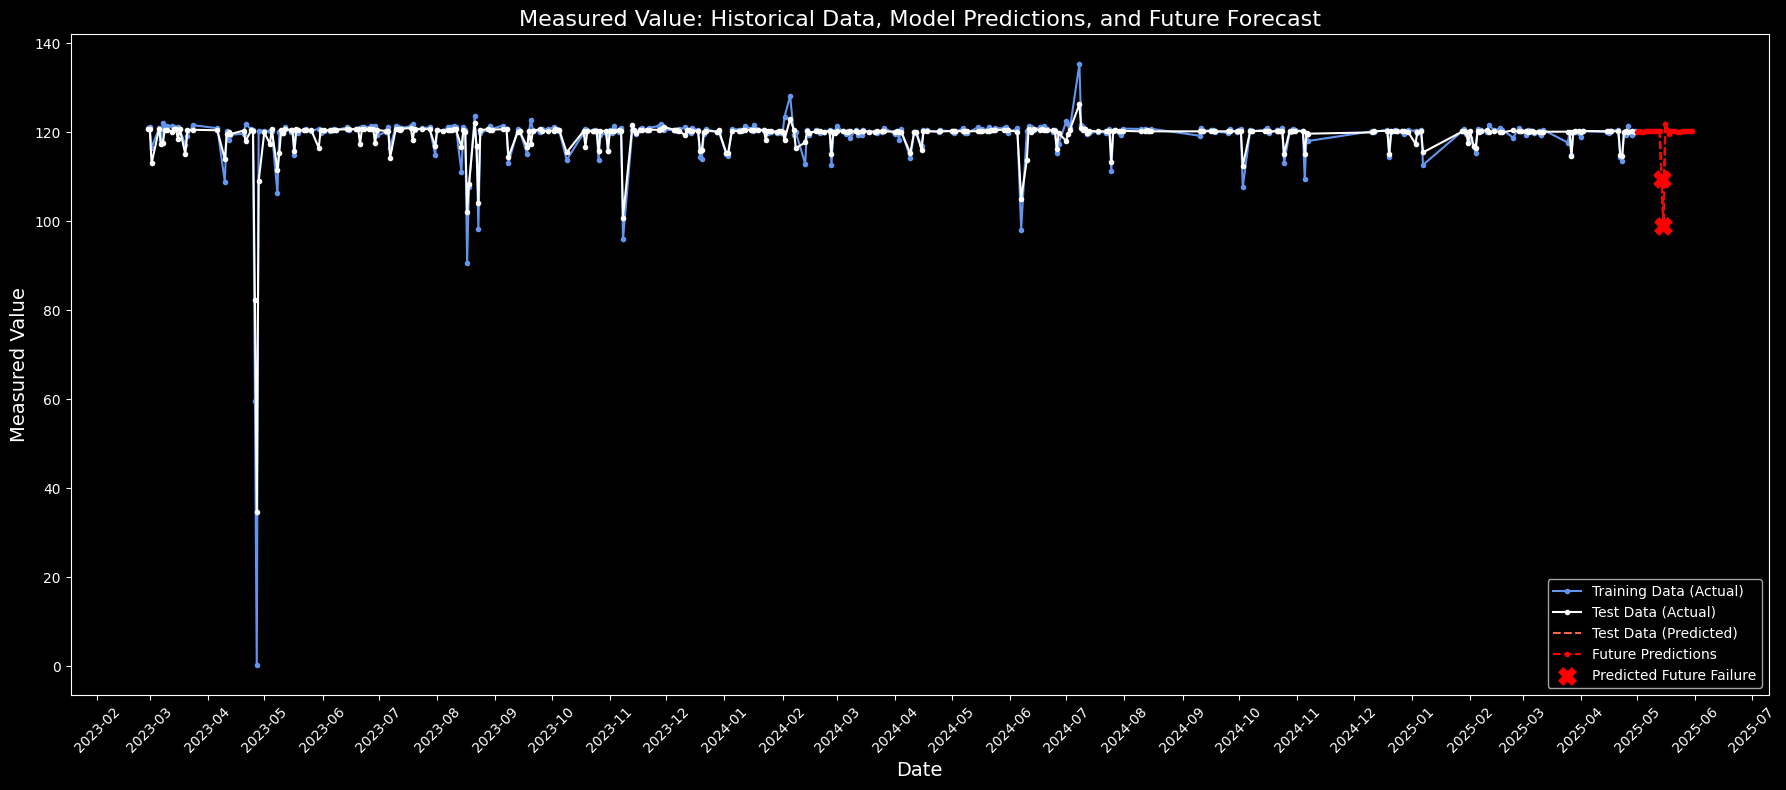

In [11]:
# Graph ploting

future_pred_df = pd.DataFrame(future_predictions)
future_fail_df = pd.DataFrame(future_failures)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(featured_df['Day'], y_reg,
        label='Training Data (Actual)', color='cornflowerblue', marker='.', linestyle='-')
ax.plot(featured_df['Day'], all_data_predictions,
        label='Test Data (Actual)', color='White', marker='.', linestyle='-')

ax.plot(future_pred_df['Day'], future_pred_df['Predicted_Value'],
        label='Test Data (Predicted)', color='tomato', marker='', linestyle='--')

if not future_pred_df.empty:
    ax.plot(future_pred_df['Day'], future_pred_df['Predicted_Value'],
            label='Future Predictions', color='red', marker='.', linestyle='--')

# Highlight future failures with a red 'X'
if not future_fail_df.empty:
    ax.scatter(future_fail_df['Day'], future_fail_df['Predicted_Value'],
               label='Predicted Future Failure', color='red', marker='X', s=150, zorder=5)

ax.set_title('Measured Value: Historical Data, Model Predictions, and Future Forecast', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Measured Value', fontsize=14)
ax.legend(loc='lower right', fontsize=10)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('measured_value.png')
plt.show()